In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings( "ignore", module = "seaborn\..*" )
import sidetable

In [38]:
# df_nba1 = pd.read_csv('2021-2022 NBA Player Stats - Regular.csv', encoding='latin1', sep=';')
# df_nba1

In [39]:
#df_nba1.columns

In [40]:
# df_nba1.rename(columns= {"Rk":"rango","Player":"jugador","Pos":"posicion","Age":"edad","Tm":"equipo",
#                                     "G":"partidos_jugados", "GS":"partidos_iniciados", "MP":"minutos_jugados",
#                                     "FG":"tiros_campo", "FGA":"intentos_campo","FG%":"tiros_campo_porc", 
#                                     "3P":"tiros_triples", "3PA":"intentos_triple", 
#                                     "3P%":"triples_porc", "2P":"tiros_dobles","2PA":"intentos_dobles", 
#                                     "2P%":"dobles_porc", "eFG%":"tiros_efectivo_porc", "FT":"tiros_libres",
#                                     "FTA":"intentos_tiros_libres",'FT%':"tiros_libres_porc", 'ORB':"rebotes_ofensivos",
#                                     "DRB":"rebotes_defensivos","TRB":"total_rebotes","AST":"asistencias",
#                                     "STL":"robos","BLK":"bloqueos","TOV":"perdidas_balon","PF":"faltas_personales",
#                                     "PTS":"total_puntos"
#                                     },inplace=True)
# df_nba1.columns

### Ideas

- Crear columnas de porcentajes de por ejemplo: total rebotes, bloqueos, asistencias...(limpieza 2).
- Buscar datos de altura y salario
- Cambiar nombre de jugadores, equipo y posición
- Hacer una regresión. Probar con cual se ajusta mejor.

In [41]:
df_nba = pd.read_csv('nba_regionales.csv', index_col=0)

In [42]:
df_nba

,rango,jugador,posicion,edad,equipo,partidos_jugados,partidos_iniciados,minutos_jugados,tiros_campo,intentos_campo,...,tiros_libres_porc,rebotes_ofensivos,rebotes_defensivos,total_rebotes,asistencias,robos,bloqueos,perdidas_balon,faltas_personales,total_puntos
0,1,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,...,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,2,Steven Adams,C,28,MEM,76,75,26.3,2.8,5.1,...,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,3,Bam Adebayo,C,24,MIA,56,56,32.6,7.3,13.0,...,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,4,Santi Aldama,PF,21,MEM,32,0,11.3,1.7,4.1,...,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
4,5,LaMarcus Aldridge,C,36,BRK,47,12,22.3,5.4,9.7,...,0.873,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,601,Thaddeus Young,PF,33,TOR,26,0,18.3,2.6,5.5,...,0.481,1.5,2.9,4.4,1.7,1.2,0.4,0.8,1.7,6.3
808,602,Trae Young,PG,23,ATL,76,76,34.9,9.4,20.3,...,0.904,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4
809,603,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,...,0.623,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3
810,604,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,...,0.776,1.9,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2


In [43]:
df_nba.shape

(812, 30)

In [44]:
df_nba.rango.value_counts()

386    5
535    4
538    4
180    4
163    4
      ..
207    1
206    1
205    1
204    1
605    1
Name: rango, Length: 605, dtype: int64

In [45]:
df_nba.describe().T

,count,mean,std,min,25%,50%,75%,max
rango,812.0,304.501232,172.637333,1.0,158.75000,300.5000,459.00000,605.0
edad,812.0,26.051724,4.059640,19.0,23.00000,25.0000,29.00000,41.0
partidos_jugados,812.0,36.704433,25.899099,1.0,12.00000,36.5000,61.00000,82.0
partidos_iniciados,812.0,16.672414,23.817195,0.0,0.00000,4.0000,25.00000,82.0
minutos_jugados,812.0,18.265394,9.648292,1.0,10.50000,17.5000,25.72500,43.5
tiros_campo,812.0,2.869951,2.223988,0.0,1.20000,2.4000,3.90000,11.4
intentos_campo,812.0,6.386576,4.651121,0.0,3.00000,5.1500,8.72500,21.8
tiros_campo_porc,812.0,0.426235,0.148525,0.0,0.38075,0.4395,0.50000,1.0
tiros_triples,812.0,0.871305,0.841935,0.0,0.20000,0.7000,1.40000,4.5
intentos_triple,812.0,2.560591,2.205642,0.0,0.80000,2.0500,3.90000,11.7


- El mínimo de edad es 19 y el máximo 41. La edad media de retirada de los jugadores es de 32. 
- En todas las variables hay algún o algunos jugadores que tienen de media 0 pts.
- En partidos jugados y minutos jugados se ve que todos han jugado.

In [46]:
df_nba.stb.missing()

,missing,total,percent
rango,0,812,0.0
jugador,0,812,0.0
faltas_personales,0,812,0.0
perdidas_balon,0,812,0.0
bloqueos,0,812,0.0
robos,0,812,0.0
asistencias,0,812,0.0
total_rebotes,0,812,0.0
rebotes_defensivos,0,812,0.0
rebotes_ofensivos,0,812,0.0


- No hay valores nulos, el dataset está bastante limpio. Veamos los outliers:

In [47]:
df_nba.dtypes

rango                      int64
jugador                   object
posicion                  object
edad                       int64
equipo                    object
partidos_jugados           int64
partidos_iniciados         int64
minutos_jugados          float64
tiros_campo              float64
intentos_campo           float64
tiros_campo_porc         float64
tiros_triples            float64
intentos_triple          float64
triples_porc             float64
tiros_dobles             float64
intentos_dobles          float64
dobles_porc              float64
tiros_efectivo_porc      float64
tiros_libres             float64
intentos_tiros_libres    float64
tiros_libres_porc        float64
rebotes_ofensivos        float64
rebotes_defensivos       float64
total_rebotes            float64
asistencias              float64
robos                    float64
bloqueos                 float64
perdidas_balon           float64
faltas_personales        float64
total_puntos             float64
dtype: obj

In [48]:
numericas = df_nba.select_dtypes(include=np.number)

In [49]:
numericas.shape

(812, 27)

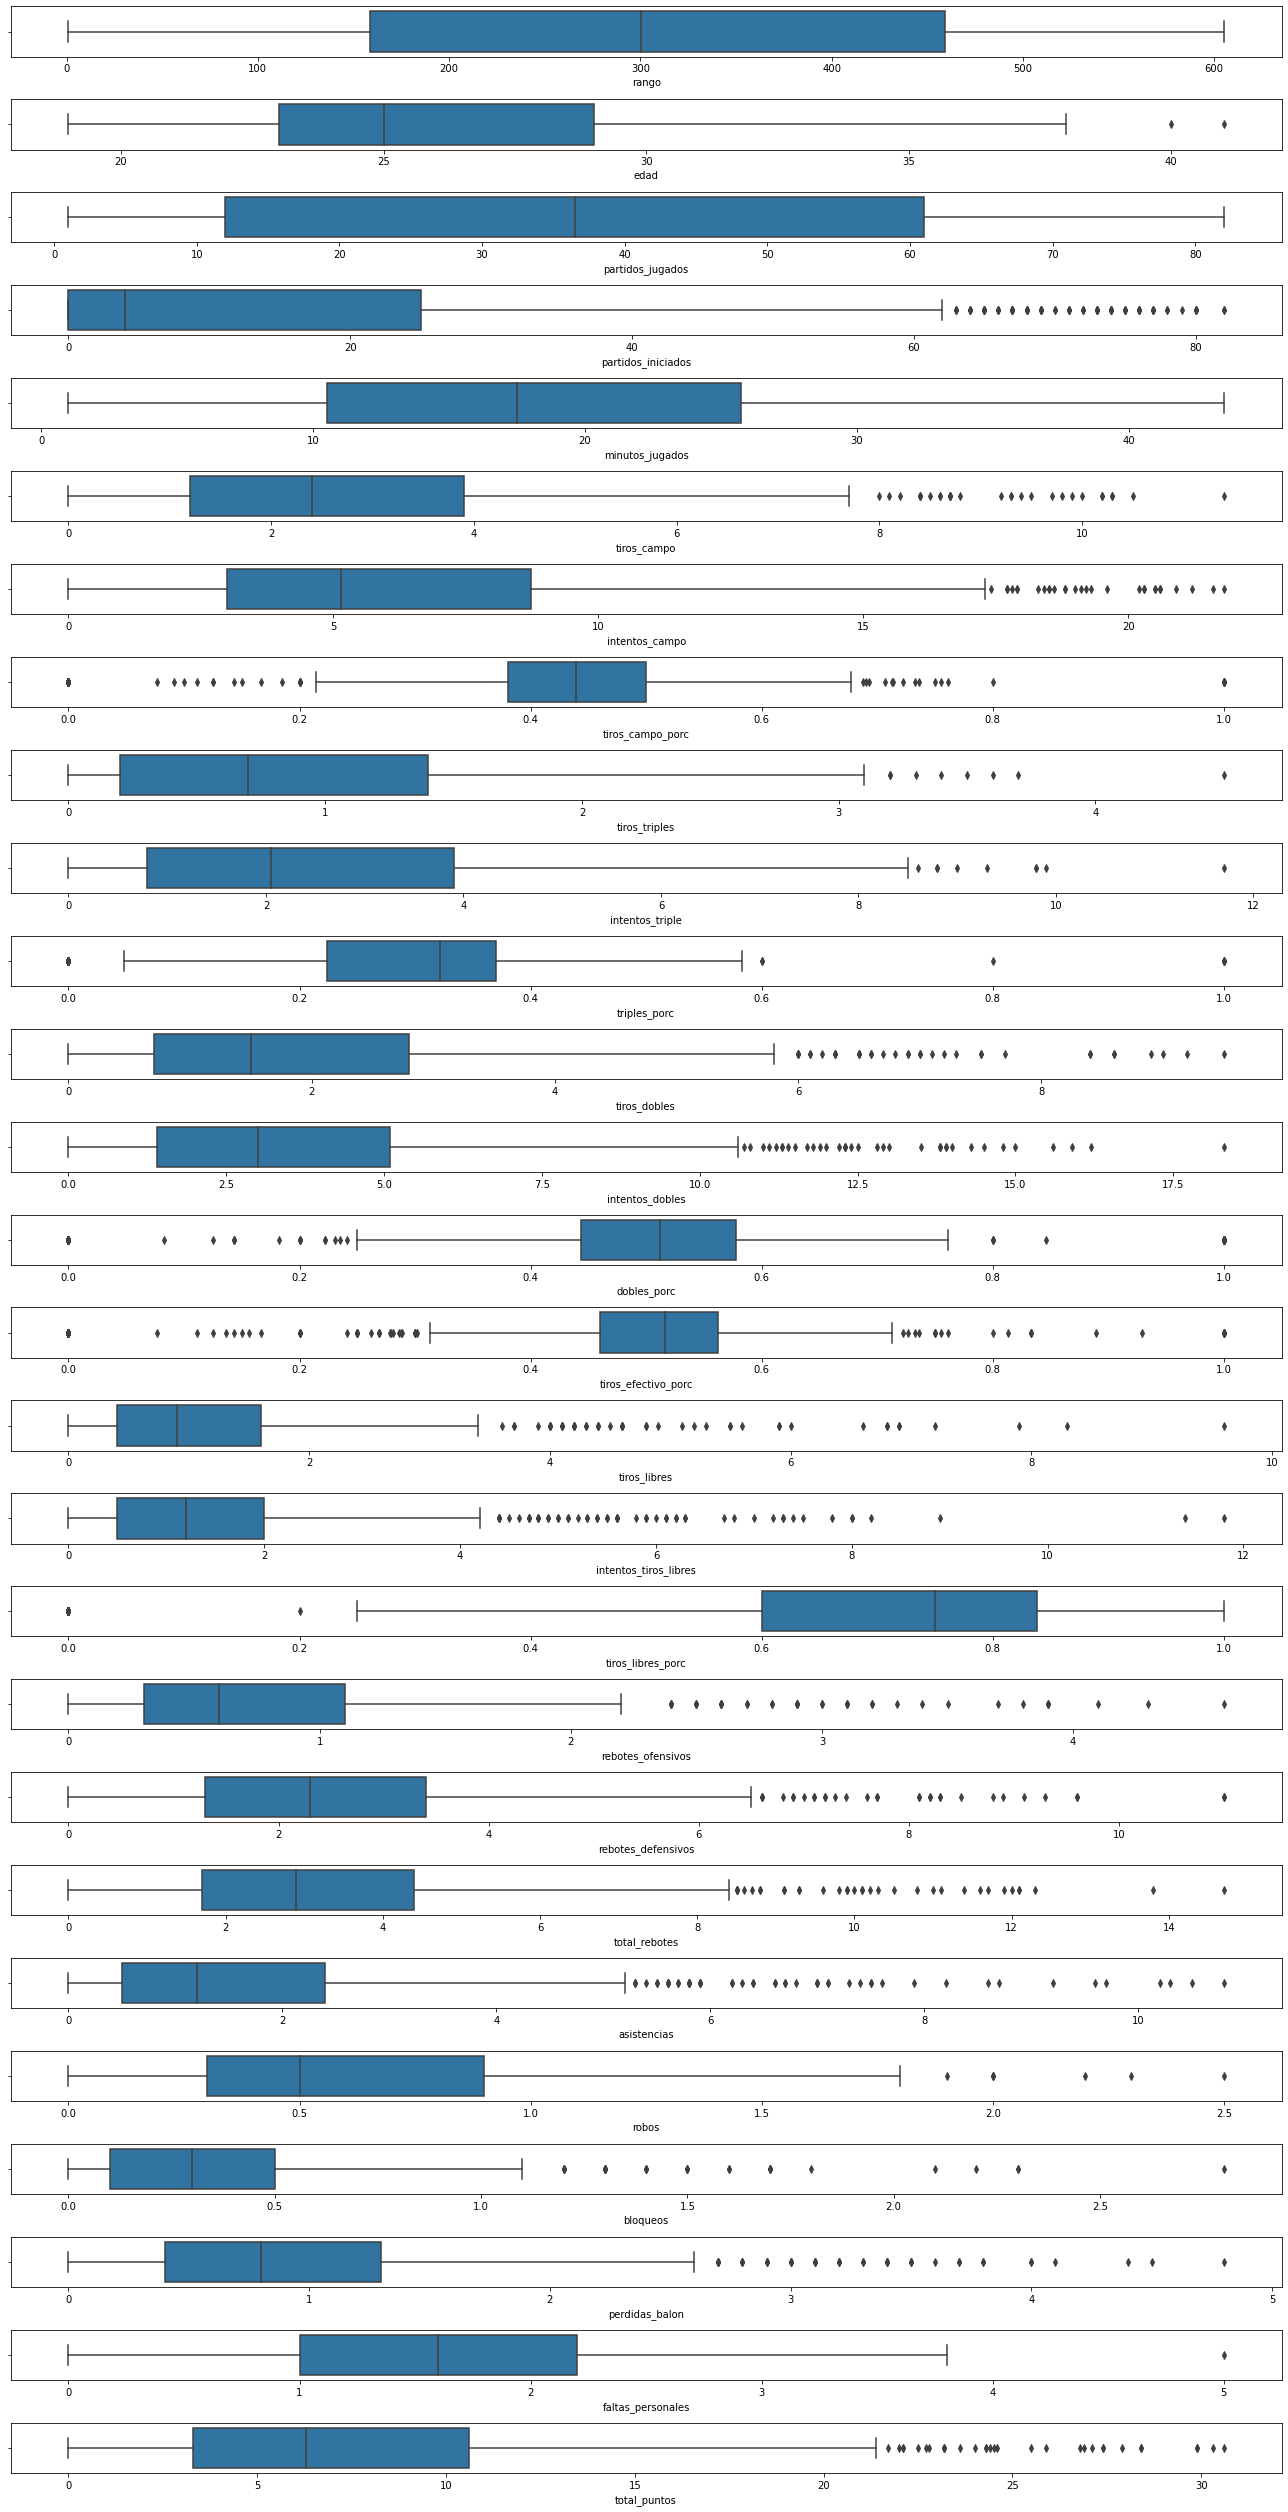

In [50]:
fig, axes = plt.subplots(27, 1, figsize=(18,35))

for i, col in enumerate(numericas.columns):
    sns.boxplot(x = numericas.columns[i], data = df_nba, ax=axes[i]); # para trazar una línea de densidad

plt.tight_layout()

plt.show()

No reemplazaré ningún outlier porque todos pueden ser importantes. Ya que serán los mejores y 'peores' jugadores de la temporada.

In [51]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df_nba[col], 25)
        Q3 = np.nanpercentile(df_nba[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    
    return dicc_indices 

In [52]:
lista_columnas = list(numericas.columns)
indices = detectar_outliers(lista_columnas, df_nba)

In [53]:
indices

{'edad': [298, 382],
 'partidos_iniciados': [1,
  15,
  18,
  32,
  34,
  35,
  38,
  39,
  40,
  41,
  58,
  66,
  70,
  77,
  78,
  93,
  108,
  112,
  138,
  152,
  155,
  156,
  159,
  167,
  178,
  200,
  206,
  219,
  229,
  246,
  257,
  260,
  262,
  267,
  270,
  276,
  282,
  292,
  324,
  325,
  333,
  360,
  367,
  383,
  391,
  397,
  433,
  442,
  455,
  462,
  484,
  507,
  515,
  516,
  533,
  540,
  560,
  582,
  592,
  593,
  605,
  617,
  630,
  643,
  645,
  667,
  679,
  702,
  707,
  708,
  736,
  737,
  738,
  743,
  747,
  748,
  751,
  753,
  774,
  782,
  797,
  808,
  811],
 'tiros_campo': [15,
  48,
  70,
  93,
  159,
  160,
  167,
  178,
  198,
  206,
  230,
  246,
  251,
  254,
  355,
  356,
  368,
  391,
  442,
  490,
  491,
  492,
  515,
  526,
  540,
  667,
  708,
  736,
  808],
 'intentos_campo': [15,
  48,
  70,
  93,
  159,
  160,
  167,
  178,
  198,
  206,
  230,
  251,
  254,
  355,
  356,
  368,
  391,
  442,
  452,
  490,
  491,
  492,
  515,
  

In [54]:
df_nba

,rango,jugador,posicion,edad,equipo,partidos_jugados,partidos_iniciados,minutos_jugados,tiros_campo,intentos_campo,...,tiros_libres_porc,rebotes_ofensivos,rebotes_defensivos,total_rebotes,asistencias,robos,bloqueos,perdidas_balon,faltas_personales,total_puntos
0,1,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,...,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,2,Steven Adams,C,28,MEM,76,75,26.3,2.8,5.1,...,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,3,Bam Adebayo,C,24,MIA,56,56,32.6,7.3,13.0,...,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,4,Santi Aldama,PF,21,MEM,32,0,11.3,1.7,4.1,...,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
4,5,LaMarcus Aldridge,C,36,BRK,47,12,22.3,5.4,9.7,...,0.873,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,601,Thaddeus Young,PF,33,TOR,26,0,18.3,2.6,5.5,...,0.481,1.5,2.9,4.4,1.7,1.2,0.4,0.8,1.7,6.3
808,602,Trae Young,PG,23,ATL,76,76,34.9,9.4,20.3,...,0.904,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4
809,603,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,...,0.623,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3
810,604,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,...,0.776,1.9,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2


Veamos si hay duplicados

In [55]:
df_nba.duplicated().sum() 

0

Como hemos dicho antes, es un df bastante limpio

In [56]:
df_nba_cambios = df_nba.copy()

In [57]:
def minusculas(df):
    for indice in range(len(df)):
        try:
            df[indice] = df[indice].replace(" ", "_").lower()

        except:
            pass

    
minusculas(df_nba_cambios['jugador'])

/tmp/ipykernel_9252/3701174409.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[indice] = df[indice].replace(" ", "_").lower()


In [59]:
df_nba_cambios

,rango,jugador,posicion,edad,equipo,partidos_jugados,partidos_iniciados,minutos_jugados,tiros_campo,intentos_campo,...,tiros_libres_porc,rebotes_ofensivos,rebotes_defensivos,total_rebotes,asistencias,robos,bloqueos,perdidas_balon,faltas_personales,total_puntos
0,1,precious_achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,...,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,2,steven_adams,C,28,MEM,76,75,26.3,2.8,5.1,...,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,3,bam_adebayo,C,24,MIA,56,56,32.6,7.3,13.0,...,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,4,santi_aldama,PF,21,MEM,32,0,11.3,1.7,4.1,...,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
4,5,lamarcus_aldridge,C,36,BRK,47,12,22.3,5.4,9.7,...,0.873,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,601,thaddeus_young,PF,33,TOR,26,0,18.3,2.6,5.5,...,0.481,1.5,2.9,4.4,1.7,1.2,0.4,0.8,1.7,6.3
808,602,trae_young,PG,23,ATL,76,76,34.9,9.4,20.3,...,0.904,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4
809,603,omer_yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,...,0.623,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3
810,604,cody_zeller,C,29,POR,27,0,13.1,1.9,3.3,...,0.776,1.9,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2
